# Hyperparameter Optimization for fine-tuning pre-trained Transformer Models from HuggingFace

In this notebook, we will show how we can use Syne Tune to optimize the hyperparameters of pre-trained transformers
from Hugging Face when we fine tune them on NLP datasets from the GLUE benchmark suite.

## Setup

Install Syne Tune

In [1]:
!pip install 'syne-tune'

Install HuggingFace dependencies

In [ ]:
!pip install 'torch==1.10.0' 'datasets==1.8.0' 'transformers'

In [1]:
import matplotlib as mpl #$; mpl.use('pgf')
import os

%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

from syne_tune.backend.local_backend import LocalBackend
from syne_tune.tuner import Tuner
from syne_tune.config_space import uniform, loguniform, choice, randint
from syne_tune.stopping_criterion import StoppingCriterion
from syne_tune.optimizer.baselines import ASHA, MOBSTER, BayesianOptimization, RandomSearch, MOASHA
from syne_tune.constants import ST_WORKER_TIME
from syne_tune.backend.sagemaker_backend.instance_info import select_instance_type
from syne_tune.backend.sagemaker_backend.sagemaker_backend import SageMakerBackend
from syne_tune.backend.sagemaker_backend.sagemaker_utils import get_execution_role


TASK2METRICSMODE = {
    "cola": {'metric': 'matthews_correlation', 'mode': 'max'},
    "mnli": {'metric': 'accuracy', 'mode': 'max'},
    "mrpc": {'metric': 'f1', 'mode': 'max'},
    "qnli": {'metric': 'accuracy', 'mode': 'max'},
    "qqp": {'metric': 'f1', 'mode': 'max'},
    "rte": {'metric': 'accuracy', 'mode': 'max'},
    "sst2": {'metric': 'accuracy', 'mode': 'max'},
    "stsb": {'metric': 'spearmanr', 'mode': 'max'},
    "wnli": {'metric': 'accuracy', 'mode': 'max'},
}

## Optimizing Training Hyperparameters 

We start by optimizing hyperparameters that control the training process: learning rate, batch size and the ratio of training steps for warming up the learning rate, i.e where the learning rate is increased to its final value before we start decaying it back to 0.

We first need to define some additional parameters such as the dataset, the total number of runtime dedicated to the HPO process and the number of workers to distributed the evaluation of hyperparameters, etc. 
We set the number of workers equal to the number of GPUs, such that each GPU evaluates one configuration at a time.

In [6]:
dataset = 'rte'
max_runtime = 1800
num_train_epochs = 3 
n_workers = 1
seed = 1234
model_type = 'bert-base-cased'

For Syne Tune we need to define which metric we would like to optimize, and whether we maximize or minimize this metirc. Additionally, we also specify the resource attribute that determines how much resources we spend for the evaluation of a hyperparameter configuration, e.g the number of epochs for training.

In [7]:
metric = 'eval_' + TASK2METRICSMODE[dataset]['metric']
mode = TASK2METRICSMODE[dataset]['mode']
resource_attribute = 'epoch'

Next we define the path to the training scripts that gets the hyperparameters as input argument and reports the above define metrics back to Syne Tune. Here we use an adated version of the original Hugging Face script: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py

In [8]:
entry_point = "./run_glue.py"

The first configuration that we will always evaluate is the default configuration provided by Hugging Face. This makes sure that the configuration returned by Syne Tune performs at least as well as the default configuration.

In [9]:
default = {
    'learning_rate': 2e-5,
    'per_device_train_batch_size': 32,
    'warmup_ratio': 0.0,
}

Now we can define the configuration space, which contains the hyperparameters that we want to optimize plus all other parameters that we want to pass to the training script.

In [10]:
config_space = {
    'learning_rate': loguniform(1e-6, 1e-4),
    'per_device_train_batch_size': randint(16, 48),
    'warmup_ratio': uniform(0, 0.5),
    'num_train_epochs': num_train_epochs,
    'model_name_or_path': model_type,
    'task_name': dataset,
    'do_train': True,
    'max_seq_length': 128,
    'seed': seed,
    'output_dir': 'tmp/' + dataset,
    'evaluation_strategy': 'epoch', 
}

Before we can start the optimization process, we have to define the backend. Here we use the LocalBackend, which distributes the HPO process on the local machine. Later we will also see how we can parallelize the search across a set of SageMaker training jobs.

In [11]:
backend = LocalBackend(entry_point=entry_point)

We use ASHA (asynchronous successive halving) as HPO method, which samples configurations randomly and terminates poorly performing configurations early.

In [12]:
scheduler = ASHA(config_space, metric=metric,
                 resource_attr=resource_attribute, max_t=num_train_epochs,
                 mode=mode, random_seed=seed, points_to_evaluate=[default])

Now we have everything together to start the optimization process.

In [13]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_runtime)
tuner = Tuner(
    trial_backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
)
tuner.run()

--------------------
Resource summary (last result is reported):
 trial_id      status  iter  learning_rate  per_device_train_batch_size  warmup_ratio  num_train_epochs model_name_or_path task_name  do_train  max_seq_length  seed output_dir evaluation_strategy  eval_loss  eval_accuracy  eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch   step  test_loss  test_accuracy   num_params   latency  worker-time
        0     Stopped     3       0.000020                           32      0.000000                 3    bert-base-cased       rte      True             128  1234    tmp/rte               epoch   0.636825       0.642570        5.6867                  131.358                 16.530    3.0  165.0   0.668089       0.624549  108311810.0  9.267124   124.313063
        1     Stopped     1       0.000007                           40      0.383173                 3    bert-base-cased       rte      True             128  1234    tmp/rte               epoch   0.707350       0.

Below we plot the test error of the best found model over time. As reference we plot the learning curve (red dots) of the default configuration, which, as explained above, is always evaluated first.
We can see that Syne Tune quickly finds a better performing configurations that improves upon the default configuration.

Text(0.5, 0, 'wall-clock time (seconds)')

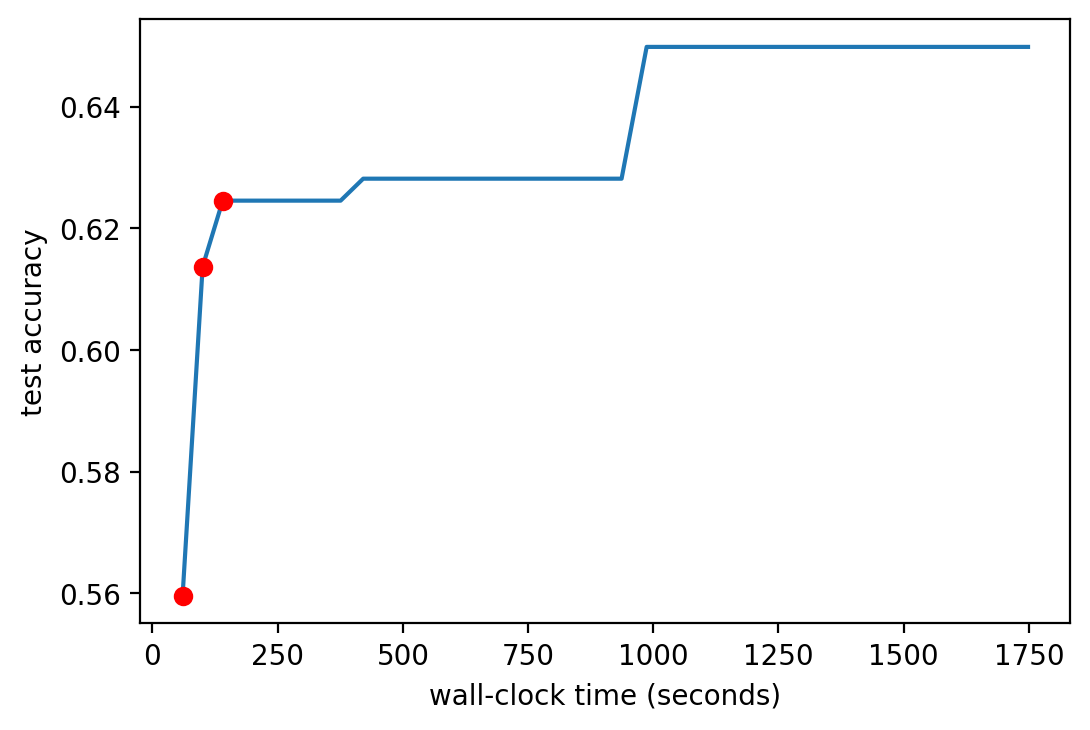

In [14]:
from syne_tune.experiments import load_experiment
exp = load_experiment(tuner.name)
df_hyperparameters = exp.results

plt.figure(dpi=200)

traj = df_hyperparameters['test_accuracy'].cummax()
runtime = df_hyperparameters['st_tuner_time']
plt.plot(runtime, traj)

df_default = df_hyperparameters[df_hyperparameters['trial_id'] == 0]
traj = df_default['test_accuracy'].cummax()
runtime = df_default['st_tuner_time']
plt.plot(runtime, traj, 'ro')

plt.ylabel('test accuracy')
plt.xlabel('wall-clock time (seconds)')

## Optimize the choice of the model

We extend the HPO such that it also automatically selected the right pre-trained model for us. We can achieve this by adding an additional categorical hyperparameter to our search space, that encodes the choice of the pre-trained model.

In [15]:
config_space['model_name_or_path'] = choice(['bert-base-cased', 'bert-base-uncased', 'distilbert-base-uncased',
                                             'distilbert-base-cased', 'roberta-base',
                                             'albert-base-v2', 'distilroberta-base',
                                             'xlnet-base-cased', 'albert-base-v1',
                                             ])

default['model_name_or_path'] = 'bert-base-cased'

Now we run the search again under the same conditions as before.

In [16]:
backend = LocalBackend(entry_point=entry_point)
scheduler = ASHA(config_space, metric=metric,
                 resource_attr=resource_attribute, max_t=num_train_epochs,
                 mode=mode, random_seed=seed, points_to_evaluate=[default])

stop_criterion = StoppingCriterion(max_wallclock_time=max_runtime)
tuner = Tuner(
    trial_backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
)
tuner.run()

--------------------
Resource summary (last result is reported):
 trial_id      status  iter  learning_rate  per_device_train_batch_size  warmup_ratio  num_train_epochs       model_name_or_path task_name  do_train  max_seq_length  seed output_dir evaluation_strategy  eval_loss  eval_accuracy  eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  step  test_loss  test_accuracy  num_params    latency  worker-time
        0     Stopped     3       0.000020                           32      0.000000                 3          bert-base-cased       rte      True             128  1234    tmp/rte               epoch   0.636825       0.642570        5.6780                  131.560                 16.555      3   165   0.668089       0.624549   108311810   9.219460   126.828884
        1     Stopped     1       0.000007                           40      0.383173                 3    distilbert-base-cased       rte      True             128  1234    tmp/rte               epoch   0

After the search is finished, we compare the results to our previous results. We can see that optimizing in this augmented search space allows Syne Tune to find a much better performing hyperparameter configuration in the same amount of time.

Text(0.5, 0, 'wall-clock time (seconds)')

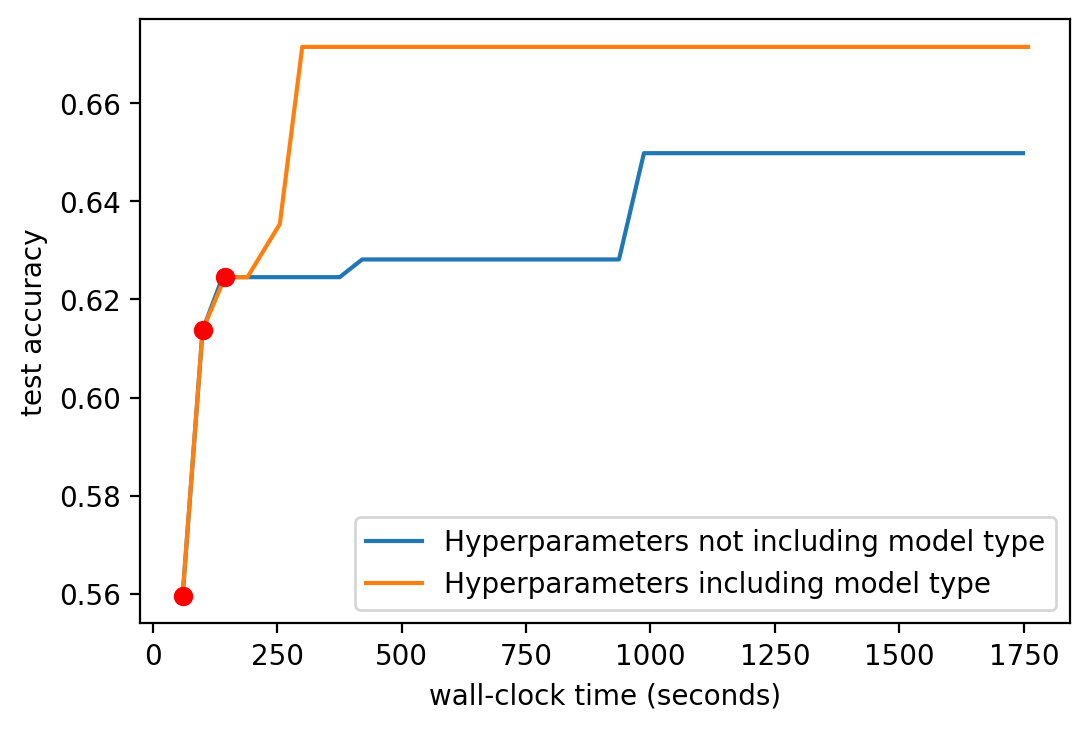

In [18]:
from syne_tune.experiments import load_experiment
exp_model_choice = load_experiment(tuner.name)
df_model_choice = exp_model_choice.results

plt.figure(dpi=200)


traj = df_hyperparameters['test_accuracy'].cummax()
runtime = df_hyperparameters['st_tuner_time']
plt.plot(runtime, traj, label='Hyperparameters not including model type')

traj = df_model_choice['test_accuracy'].cummax()
runtime = df_model_choice['st_tuner_time']
plt.plot(runtime, traj, label='Hyperparameters including model type')

df_default = df_model_choice[df_model_choice['trial_id'] == 0]
traj = df_default['test_accuracy'].cummax()
runtime = df_default['st_tuner_time']
plt.plot(runtime, traj, 'ro')

plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('wall-clock time (seconds)')

## Optimize the Instance Type

Last, we additionally automate the selection of the instance type for deploying the model later. While this will not affect predictive performance, the instance type influences the latency and the cost of training the model.
Thus, we do not optimize a single objective anymore but multiple objectives at the same time. The results is not a single configuration but a set of configuratios that optimially trade-off one metric vs the other.

The same as with the model choice, we will add an additional categorical hyperparameter that determines the instance type. For this example, we have to use the SageMaker backend of Syne Tune, which evaluates each hyperparameter configuration in a single SageMaker Training Job.

In [19]:
from sagemaker.huggingface import HuggingFace

instance_types = ['ml.g4dn.xlarge', 'ml.g4dn.2xlarge', 'ml.p2.xlarge', 'ml.g4dn.4xlarge',
                  'ml.g4dn.8xlarge', 'ml.p3.2xlarge', 'ml.g5.xlarge', 'ml.g5.2xlarge',
                  'ml.g5.4xlarge', 'ml.g5.8xlarge']

config_space['st_instance_type'] = choice(instance_types)

backend = SageMakerBackend(
    sm_estimator=HuggingFace(
        entry_point=str('run_glue.py'),
        source_dir=os.getcwd(),
        base_job_name='glue-moasha',
        # instance-type given here are override by Syne Tune with values sampled from `st_instance_type`.
        instance_type='ml.m5.large',
        instance_count=1,
        py_version="py38",
        pytorch_version='1.9',
        transformers_version='4.12',
        max_run=3600,
        role=get_execution_role(),
    ),
)

Instead of single-objective ASHA, we now use MO-ASHA to optimize multiple objective simultaneously. 

In [20]:
from syne_tune.constants import ST_WORKER_COST

scheduler = MOASHA(
    max_t=num_train_epochs,
    time_attr=resource_attribute,
    metrics=[metric, 'latency', ST_WORKER_COST],
    mode=[mode, 'min', 'min'],
    config_space=config_space,
)
stop_criterion = StoppingCriterion(max_wallclock_time=10800)
tuner = Tuner(
    trial_backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=4,
)
tuner.run()

adding trial 0
adding trial 1
adding trial 2
adding trial 3
adding trial 4
adding trial 5
adding trial 6
adding trial 7
adding trial 8
adding trial 9
adding trial 10
adding trial 11
adding trial 12
adding trial 13
adding trial 14
adding trial 15
adding trial 16
adding trial 17
adding trial 18
adding trial 19
adding trial 20
adding trial 21
adding trial 22
adding trial 23
adding trial 24
adding trial 25
adding trial 26
adding trial 27
adding trial 28
adding trial 29
adding trial 30
adding trial 31
adding trial 32
adding trial 33
adding trial 34
adding trial 35
adding trial 36
adding trial 37
adding trial 38
adding trial 39
adding trial 40
adding trial 41
adding trial 42
adding trial 43
adding trial 44
adding trial 45
adding trial 46
adding trial 47
adding trial 48
adding trial 49
adding trial 50
adding trial 51
adding trial 52
adding trial 53
adding trial 54
adding trial 55
adding trial 56
adding trial 57
adding trial 58
adding trial 59
adding trial 60
adding trial 61
adding trial 62
ad

Below we plot the latency and cost of all configurations that we trained for the full amount of epochs. The color indicated the instance type. We also plot the Pareto front (dashed black line), i.e the set of configurations that dominate all other configurations in at least one objective and equally well in all other objectives.

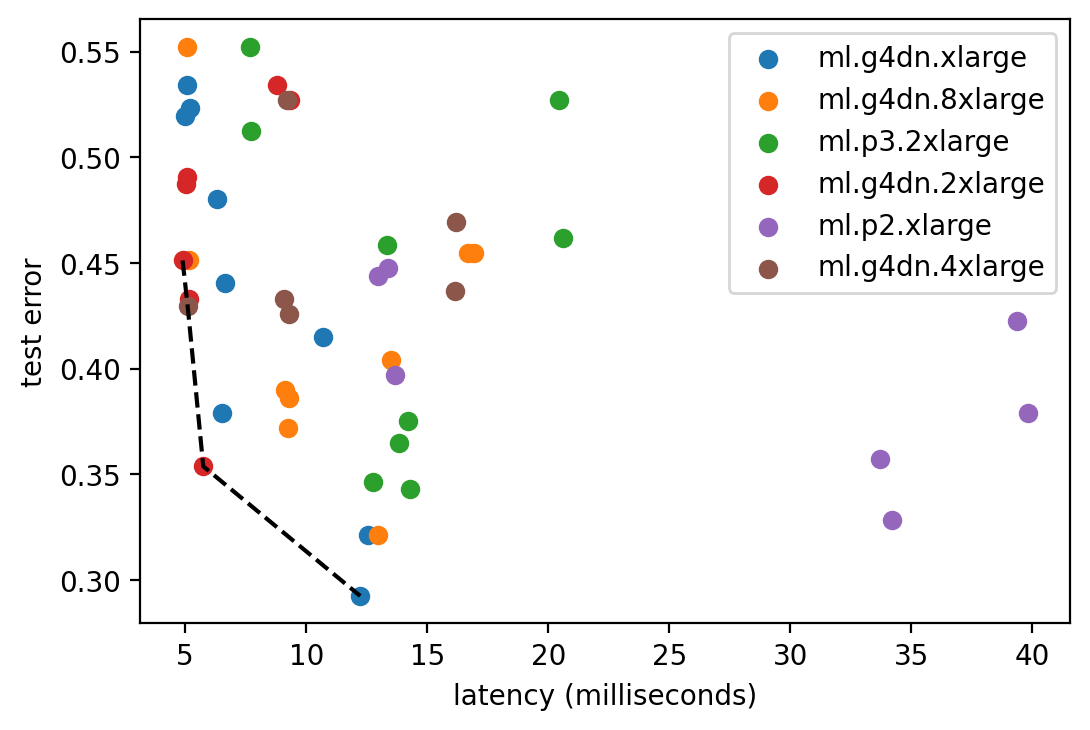

In [21]:
import numpy as np

from syne_tune.constants import ST_WORKER_COST
from syne_tune.experiments import load_experiment


def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

exp = load_experiment(tuner.name)

# exp = load_experiment('run-glue-2022-03-14-13-13-33-820')
df = exp.results
metric_name = 'test_accuracy'

df = df[df['epoch'] == 3]

markers = ['o', 'D', 's', 'x', 'p', 'h']

plt.figure(dpi=200)

x = df['latency']
y = 1 - df[metric_name]

data = np.array([x, y]).T
idx = is_pareto_efficient(data)
sort = np.argsort(data[idx, 0])
plt.step(data[idx, 0][sort], data[idx, 1][sort], linestyle='--', color='k')

for i, instance_type in enumerate(df.config_st_instance_type.unique()):
    sub_df = df[df['config_st_instance_type'] == instance_type]
    plot_label = True
    for j, model_type in enumerate(df.config_model_name_or_path.unique()):
        
        sub_sub_df = sub_df[sub_df['config_model_name_or_path'] == model_type]
        x = sub_sub_df['latency']
        y = 1 - sub_sub_df[metric_name]
        if plot_label:
            plt.scatter(x, y, color='C%d' % i, marker='o', label=instance_type)
            plot_label = False
        else:
            plt.scatter(x, y, color='C%d' % i, marker='o')

plt.ylabel('test error')
plt.xlabel('latency (milliseconds)')
plt.legend()
plt.show()


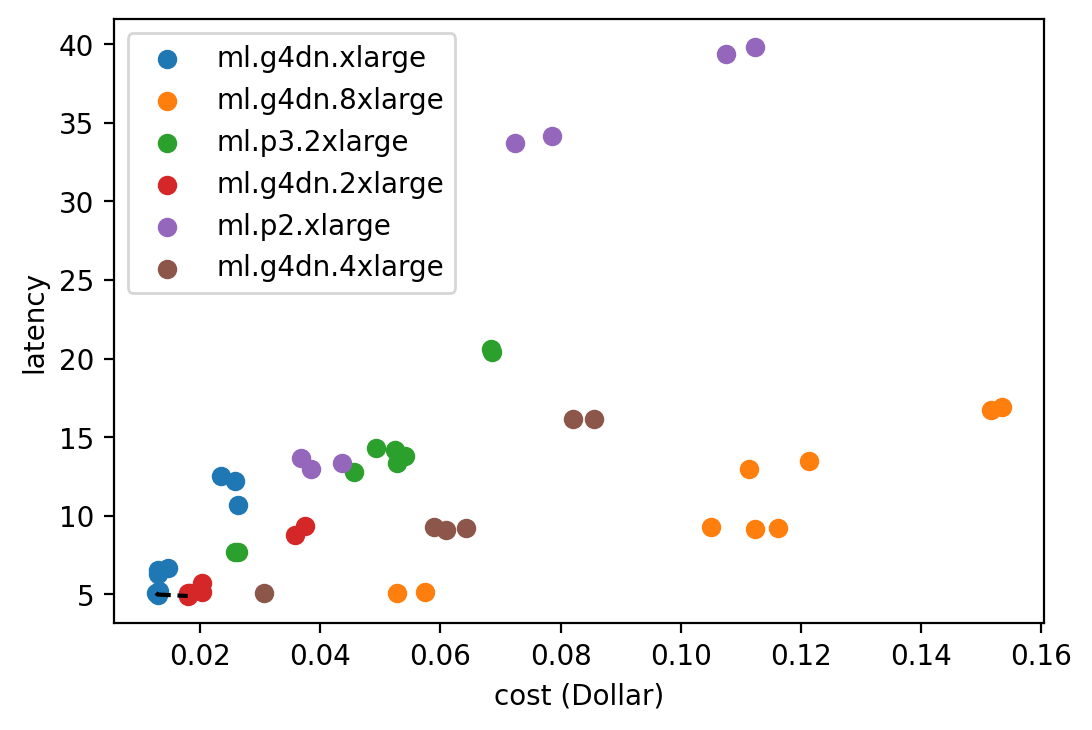

In [23]:
plt.figure(dpi=200)

x = df[ST_WORKER_COST]
y = df['latency']

data = np.array([x, y]).T
idx = is_pareto_efficient(data)
sort = np.argsort(data[idx, 0])
plt.plot(data[idx, 0][sort], data[idx, 1][sort], linestyle='--', color='k')

for i, instance_type in enumerate(df.config_st_instance_type.unique()):
    sub_df = df[df['config_st_instance_type'] == instance_type]
    plot_label = True
    for j, model_type in enumerate(df.config_model_name_or_path.unique()):
        
        sub_sub_df = sub_df[sub_df['config_model_name_or_path'] == model_type]
        x = sub_sub_df[ST_WORKER_COST]
        y = sub_sub_df['latency']
        
        if plot_label:
            plt.scatter(x, y, color='C%d' % i, marker='o', label=instance_type)
            plot_label = False
        else:
            plt.scatter(x, y, color='C%d' % i, marker='o')

plt.ylabel('latency')
plt.xlabel('cost (Dollar)')
plt.legend()
plt.show()
